# About: Handwritten digits classification

The purpose of this project is to classify handwritten digits using MNIST dataset which contains $70000$ images of size $28\times 28$ pixels, labeled from 0 to 9. We will use different techniques such as *Multivariate Regression, Linear Discriminant Analysis (LDA), Quadratic Discriminant Analysis (QDA)* and *Logistic Regression*.

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
import seaborn as sns
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics
import statsmodels.api as sm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

%matplotlib inline

**Loading dataset:**

In [2]:
mnist = fetch_openml('mnist_784')

In [3]:
X = mnist.data
y = [int(string_number) for string_number in mnist.target]
target_names = mnist.target_names
mnist.data.shape

(70000, 784)

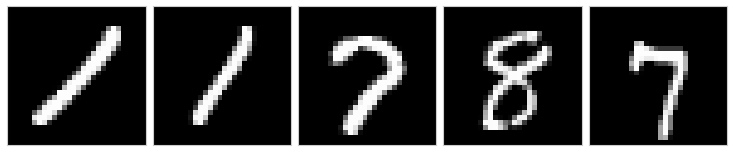

In [4]:
fig = plt.figure(figsize=(10,10)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
# plot 5 random numbers
j = 1
np.random.seed(0)
for i in np.random.choice(range(70000), 5): 
    ax = fig.add_subplot(1, 5, j, xticks=[], yticks=[]) 
    ax.imshow(np.reshape(X[i,:],(28,28)), cmap=plt.cm.gray, interpolation='nearest') 
    j += 1
plt.show()

**Plotting number frequencies:**

([<matplotlib.axis.XTick at 0x7fb1279da700>,
 [Text(0, 0, '5'),
  Text(1, 0, '0'),
  Text(2, 0, '4'),
  Text(3, 0, '1'),
  Text(4, 0, '9'),
  Text(5, 0, '2'),
  Text(6, 0, '3'),
  Text(7, 0, '6'),
  Text(8, 0, '7'),
  Text(9, 0, '8')])

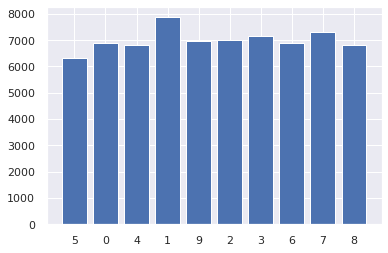

In [5]:
# counting frequencies
target_numbers_count = Counter(y).items()
target_numbers_count_dict = {}
for key, value in target_numbers_count:
    target_numbers_count_dict[key] = value


    
#plotting frequencies
sns.set(style="darkgrid")
plt.bar(range(10), list(target_numbers_count_dict.values()), align='center')
plt.xticks(range(10), list(target_numbers_count_dict.keys()))

# Multivariate Regression baseline:

The baseline we will use is given by the multivariate linear model:
$$Y=X\hat{B},$$
where $Y_{70000\times 10}$ is an indicator matrix where each row has 0 excepting the value $y_k$ where we put 1.
$X_{70000\times 784}$ is the design matrix and $\hat{B}$ is the matrix whose columns contain the 10 coefficients corresponding to $\hat{\beta_k}$. With this model, we assume a linear model for each response variable $y_k$:
$$\hat{y_k}=X\hat{\beta_k}.$$

And the classification for an observation $x$ follows the next decision rule:
$$\hat{C}(x)=\operatorname{argmax}_{k\in K}\hat{y_k}.$$

**Building Y matrix**

In [6]:
def indicator(number):
    '''
    Return a vector which contains 1 in the index position 
    given by the number. Otherwise it'll be 0.
    '''
    indicator = [0 for _ in range(10)]
    indicator[number] = 1
    return indicator

Y = map(indicator, y)
Y = np.array(list(Y))
Y[0:10] #showing the first 10 numbers

array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

**Splitting in train-test datasets**

In [7]:
X_train, X_test, y_train, y_test, Y_train, Y_test = train_test_split(X, y, Y,
                                                                     test_size = 0.2,
                                                                     random_state = 42)

**Fitting a linear model to train dataset**

In [8]:
reg = linear_model.LinearRegression()
linear_regression_model = reg.fit(X_train,Y_train)

**Classifying using the rule decision**

In [9]:
Y_hat_test = linear_regression_model.predict(X_test)
C_multivariate = map(np.argmax, Y_hat_test)  # classification vector
C_multivariate = list(C_multivariate)
C_multivariate[:5]

[8, 4, 6, 7, 7]

**Comparing predictions vs real values**

In [10]:
differences = np.array(C_multivariate) - np.array(y_test)
diff_freq = Counter(differences)
correct_predictions_count = diff_freq[0]
correct_predictions_count

11955

**proportion of correct predictions with multivariate regression (Accuracy)**

In [11]:
accuracy_multivariate = correct_predictions_count/len(y_test)
accuracy_multivariate

0.8539285714285715

**Measuring distinct errors**

In [12]:
print(metrics.classification_report(y_test, C_multivariate, digits=3))

              precision    recall  f1-score   support

           0      0.901     0.953     0.927      1343
           1      0.809     0.971     0.883      1600
           2      0.903     0.793     0.844      1380
           3      0.825     0.841     0.833      1433
           4      0.819     0.886     0.851      1295
           5      0.876     0.734     0.799      1273
           6      0.893     0.925     0.909      1396
           7      0.869     0.862     0.866      1503
           8      0.842     0.741     0.788      1357
           9      0.827     0.807     0.817      1420

    accuracy                          0.854     14000
   macro avg      0.856     0.851     0.852     14000
weighted avg      0.856     0.854     0.852     14000



# Linear Discriminant Analysis (LDA)

In [13]:
lda = LinearDiscriminantAnalysis()
lda_model = lda.fit(X_train, y_train)

In [14]:
lda_predict = lda_model.predict(X_test)
lda_predict

array([8, 4, 5, ..., 2, 7, 1])

**Measuring distinct errors:**

In [15]:
print(metrics.classification_report(y_test, lda_predict, digits=3))

              precision    recall  f1-score   support

           0      0.955     0.939     0.947      1343
           1      0.865     0.958     0.909      1600
           2      0.902     0.809     0.853      1380
           3      0.851     0.839     0.845      1433
           4      0.842     0.893     0.867      1295
           5      0.819     0.816     0.817      1273
           6      0.930     0.910     0.920      1396
           7      0.919     0.845     0.880      1503
           8      0.808     0.789     0.798      1357
           9      0.798     0.865     0.830      1420

    accuracy                          0.868     14000
   macro avg      0.869     0.866     0.867     14000
weighted avg      0.869     0.868     0.868     14000



# Quadratic Discriminant Analysis (QDA)

In [16]:
qda = QuadraticDiscriminantAnalysis()
qda_model = qda.fit(X_train, y_train)

/home/ed4st/anaconda3/envs/DS/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [17]:
qda_predict = qda_model.predict(X_test)
qda_predict

array([8, 9, 8, ..., 1, 9, 1])

**Measuring distinct errors:**

In [18]:
print(metrics.classification_report(y_test, qda_predict, digits=3))

              precision    recall  f1-score   support

           0      0.287     0.972     0.444      1343
           1      0.877     0.948     0.911      1600
           2      0.860     0.213     0.341      1380
           3      0.653     0.270     0.382      1433
           4      0.802     0.066     0.121      1295
           5      0.922     0.075     0.138      1273
           6      0.757     0.946     0.841      1396
           7      0.926     0.283     0.434      1503
           8      0.498     0.458     0.477      1357
           9      0.430     0.950     0.592      1420

    accuracy                          0.529     14000
   macro avg      0.701     0.518     0.468     14000
weighted avg      0.704     0.529     0.480     14000



# Logistic Regression

In [19]:
log_reg = linear_model.LogisticRegression(solver = 'sag', n_jobs=-1, max_iter=100, multi_class="multinomial")
logistic_model =  log_reg.fit(X_train, y_train)

/home/ed4st/anaconda3/envs/DS/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [20]:
logistic_predict = logistic_model.predict(X_test)
logistic_predict 

array([8, 4, 5, ..., 2, 7, 1])

**Measuring distinct errors:**

In [21]:
print(metrics.classification_report(y_test, logistic_predict, digits=3))

              precision    recall  f1-score   support

           0      0.957     0.960     0.958      1343
           1      0.955     0.971     0.963      1600
           2      0.906     0.891     0.899      1380
           3      0.896     0.900     0.898      1433
           4      0.919     0.921     0.920      1295
           5      0.891     0.863     0.876      1273
           6      0.935     0.951     0.943      1396
           7      0.933     0.937     0.935      1503
           8      0.886     0.873     0.879      1357
           9      0.899     0.906     0.902      1420

    accuracy                          0.919     14000
   macro avg      0.918     0.917     0.917     14000
weighted avg      0.918     0.919     0.918     14000



# Applet for prediction

In [22]:
fitted_models = [linear_regression_model, lda_model, qda_model, lda_model]

In [ ]:
from tkinter import *
from digitsTab import Predict
# ejecutamos el applet
root = Tk()
root.geometry("400x400")
root.resizable(0, 0)
app = Predict(root, fitted_models)
root.mainloop()